In [136]:
# %load_ext autoreload
# %autoreload 2

In [137]:
%reset -f

import gc
import torch

gc.collect()
torch.cuda.empty_cache()

# Imports

In [138]:
import glob
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F
import torchaudio.transforms as T
from matplotlib.ticker import ScalarFormatter
from sklearn.decomposition import PCA
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Lambda
from tqdm.notebook import tqdm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

from spec_mamba import *
from spec_mamba.exp.cfg.constants import *

warnings.filterwarnings("ignore", message=".*Can't initialize NVML.*")

%matplotlib inline

In [139]:
plt.rcParams.update({"font.size": 12})
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((4, 4))

cmap = plt.get_cmap("viridis")
colors = cmap(np.linspace(0, 1, 6))

np.random.seed(42)

In [140]:
RUN_INFERENCE = False

In [141]:
DEVICE = 2

In [142]:
test_metadata = get_split_df(TARGETS_SPLITS_DIR, "test")
test_metadata

,time,filename,th1,th1_value,th2,th2_value,th3,th3_value,wudate,datetime,...,tempAve_label,humidityAvg_label,uvHigh_label,solarRadiationHigh_label,Time_of_Day_angle,Day_of_Year_angle,Time_of_Day_sin,Time_of_Day_cos,Day_of_Year_sin,Day_of_Year_cos
sessionId,,,,,,,,,,,,,,,,,,,,,
test,_2024_05_18_5_09_17,spectrograms/one_channel/GardenFiles23/er_file...,0.177093,0.24,0.801408,0.50,0.117688,0.23,20240518,2024-05-18 05:09:17,...,0.424929,1.000000,0.000000,0.000000,1.349503,2.392775,0.975614,0.219491,0.680773,-0.732494
test,_2024_03_28_22_24_52,spectrograms/one_channel/GardenFiles23/er_file...,0.143735,0.25,0.883673,0.67,0.169790,0.27,20240328,2024-03-28 22:24:52,...,-0.090995,0.522342,0.000000,0.000000,5.868088,1.514850,-0.403279,0.915077,0.998435,0.055917
test,_2024_06_15_19_57_53,spectrograms/one_channel//GardenFiles23/er_fil...,0.315291,0.22,0.625621,0.50,0.096684,0.23,20240615,2024-06-15 19:57:53,...,0.972120,0.480740,0.000000,3.858622,5.226752,2.874772,-0.870606,0.491980,0.263665,-0.964614
test,_2024_07_05_11_39_07,spectrograms/one_channel//GardenFiles23/er_fil...,0.178793,0.20,0.887980,0.50,0.697204,0.22,20240705,2024-07-05 11:39:07,...,1.112827,0.583975,1.098612,5.483967,3.050472,3.219057,0.090995,-0.995851,-0.077386,-0.997001
test,_2024_01_22_0_35_34,spectrograms/one_channel/GardenFiles23/er_file...,0.318508,0.19,0.886567,0.50,0.368689,0.19,20240122,2024-01-22 00:35:34,...,-0.388042,0.865948,0.000000,0.000000,0.155189,0.378713,0.154567,0.987982,0.369725,0.929141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
test,_2024_03_20_14_39_19,spectrograms/one_channel/GardenFiles23/er_file...,0.331622,0.24,0.378794,0.67,0.104253,0.24,20240320,2024-03-20 14:39:19,...,1.347338,0.359014,1.609438,6.084727,3.836743,1.377137,-0.640501,-0.767958,0.981306,0.192452
test,_2023_10_24_13_05_18,spectrograms/one_channel/GardenFiles23/er_file...,0.228246,0.22,0.273017,0.50,0.007747,0.23,20231024,2023-10-24 13:05:18,...,0.284222,0.907550,0.000000,3.370738,3.426518,5.112619,-0.281085,-0.959683,-0.920971,0.389630
test,_2024_03_24_9_59_08,spectrograms/one_channel/GardenFiles23/er_file...,0.299010,0.25,0.768733,0.67,0.366776,0.27,20240324,2024-03-24 09:59:08,...,-0.388042,0.704160,1.386294,5.843544,2.614212,1.445993,0.503271,-0.864128,0.992222,0.124479


# Embeddings

In [143]:
def l2_normalize(x: torch.Tensor, dim: int = 1, eps: float = 1e-15) -> torch.Tensor:
    return F.normalize(x, p=2, dim=dim, eps=eps)


def alignment(z1: torch.Tensor, z2: torch.Tensor) -> torch.Tensor:
    return (z1 - z2).pow(2).sum(dim=1).mean()


def uniformity(z: torch.Tensor, temperature: float = 2.0) -> torch.Tensor:
    N = z.size(0)
    sim = z @ z.T
    dist2 = 2.0 - 2.0 * sim
    dist2.fill_diagonal_(float("inf"))

    return torch.logsumexp(-temperature * dist2.flatten(), dim=0) - math.log(
        N * (N - 1)
    )

In [144]:
FOUNDATION_MODELS = [
    "bimamba-cls-mae",
    "bimamba-cont",
    "bimamba-mse",
    "ssast-cont",
    "ssast-mae",
    "ssast-mse",
]
FOUNDATION_PATHS = [
    glob.glob(
        os.path.join("checkpoints_final", "pretrain", model, "weights_best_*.pt")
    )[0]
    for model in FOUNDATION_MODELS
]

In [145]:
if RUN_INFERENCE:
    foundation_models = {}

    for name, path in zip(FOUNDATION_MODELS, FOUNDATION_PATHS):
        if "mamba" in name:
            model = AudioMamba(
                spec_size=(128, 65),
                patch_size=(16, 5),
                channels=1,
                embed_dim=AUDIO_MAMBA_DEFAULT_CONFIG["tiny"]["embed_dim"],
                depth=AUDIO_MAMBA_DEFAULT_CONFIG["tiny"]["depth"],
                ssm_cfg=SSM_CONFIG,
                mask_ratio=0.0,
                mask_token_type="noise" if name == "bimamba-cont" else "learned",
                drop_path_rate=0.0,
                pos_drop_rate=0.0,
                cls_position="middle" if name == "bimamba-cls-mae" else "none",
                use_pred_head=False,
                use_rms_norm=True,
                fused_add_norm=True,
                bi_mamba_type="v1",
                output_type="mean",
            )
        else:
            model = SSAST(
                spec_size=(128, 65),
                patch_size=(16, 5),
                channels=1,
                embed_dim=SSAST_DEFAULT_CONFIG["tiny"]["embed_dim"],
                depth=SSAST_DEFAULT_CONFIG["tiny"]["depth"],
                num_heads=SSAST_DEFAULT_CONFIG["tiny"]["num_heads"],
                mlp_ratio=4,
                mask_ratio=0.0,
                mask_token_type="noise" if name == "ssast-cont" else "learned",
                drop_path_rate=0.0,
                pos_drop_rate=0.0,
                cls_position="none",
                use_pred_head=False,
                use_rms_norm=True,
                output_type="mean",
            )

        model = load_and_freeze_state_dict(model, path, strict=False)
        foundation_models[name] = model.cuda(device=DEVICE).eval()

In [146]:
if RUN_INFERENCE:
    wav_metadata = pd.read_csv(os.path.join(WAVEFORMS_LOCATION, "wav_metadata.csv"))
    wav_metadata_test = wav_metadata[
        wav_metadata["time"].isin(test_metadata["time"])
    ].reset_index(drop=True)

    wav_transform = Compose(
        [
            Lambda(lambda x: x + torch.randn_like(x) * 0.1 * x.abs().max()),
            T.Vol(gain=np.random.uniform(-5, 5), gain_type="db"),
            T.PitchShift(
                sample_rate=SAMPLE_RATE // 2, n_steps=np.random.randint(-2, 2)
            ),
        ]
    )
    spec_transform = Compose(
        [
            T.AmplitudeToDB(),
            SpecNormalize(db_min=DB_MIN, db_max=DB_MAX),
            Lambda(lambda spec: spec + torch.randn_like(spec) * 0.01),
            Lambda(
                lambda spec: torch.roll(
                    spec,
                    shifts=int(np.random.uniform(-5, 5)),
                    dims=-1,  # time axis
                )
            ),
            T.FrequencyMasking(freq_mask_param=5, iid_masks=True),
            T.TimeMasking(time_mask_param=5, iid_masks=True),
        ]
    )

    dual_dataset = DualSpecGF23Dataset(
        processor=DualSpecProcessor(
            location=WAVEFORMS_LOCATION,
            dataframe=wav_metadata_test,
            sample_rate=SAMPLE_RATE // 2,
            add_channels=True,
            n_fft=N_FFT // 2,
            mel_scale=True,
            wav_transform=wav_transform,
            spec_transform=spec_transform,
        )
    )

    batch_size = 16
    random_indices = np.random.randint(0, len(dual_dataset), size=2**13)
    foundation_dataloader = DataLoader(
        dual_dataset,
        batch_size=batch_size,
        sampler=random_indices,
        num_workers=16,
        shuffle=False,
    )

In [147]:
if RUN_INFERENCE:
    emb_results = {}

    for name, model in tqdm(foundation_models.items(), total=len(foundation_models)):
        embeds_origin = []
        embeds_aug = []

        for batch_origin, batch_aug in tqdm(
            iter(foundation_dataloader),
            total=int(np.ceil(len(random_indices) / batch_size)),
            desc=name,
            leave=False,
        ):
            spec_origin = batch_origin["spectrogram"].detach().cuda(device=DEVICE)
            spec_aug = batch_aug["spectrogram"].detach().cuda(device=DEVICE)
            assert not torch.allclose(spec_origin, spec_aug)

            with torch.no_grad():
                embed_origin, _ = model(spec_origin)
                embed_aug, _ = model(spec_aug)

            embeds_origin.append(embed_origin.detach().cpu())
            embeds_aug.append(embed_aug.detach().cpu())

        embeds_origin = torch.cat(embeds_origin, dim=0)
        embeds_aug = torch.cat(embeds_aug, dim=0)
        assert embeds_origin.shape == embeds_aug.shape == (len(random_indices), 192)

        emb_results[name] = {
            "emb": embeds_origin,
            "alignment": alignment(
                l2_normalize(embeds_origin), l2_normalize(embeds_aug)
            ).item(),
            "uniformity": uniformity(l2_normalize(embeds_origin)).item(),
        }

    with open("results/emb_results.pkl", "wb") as f:
        pickle.dump(emb_results, f)

with open("results/emb_results.pkl", "rb") as f:
    emb_results = pickle.load(f)

In [148]:
emb_results["bimamba-mae"] = emb_results.pop("bimamba-cls-mae")
emb_results = dict(sorted(emb_results.items()))

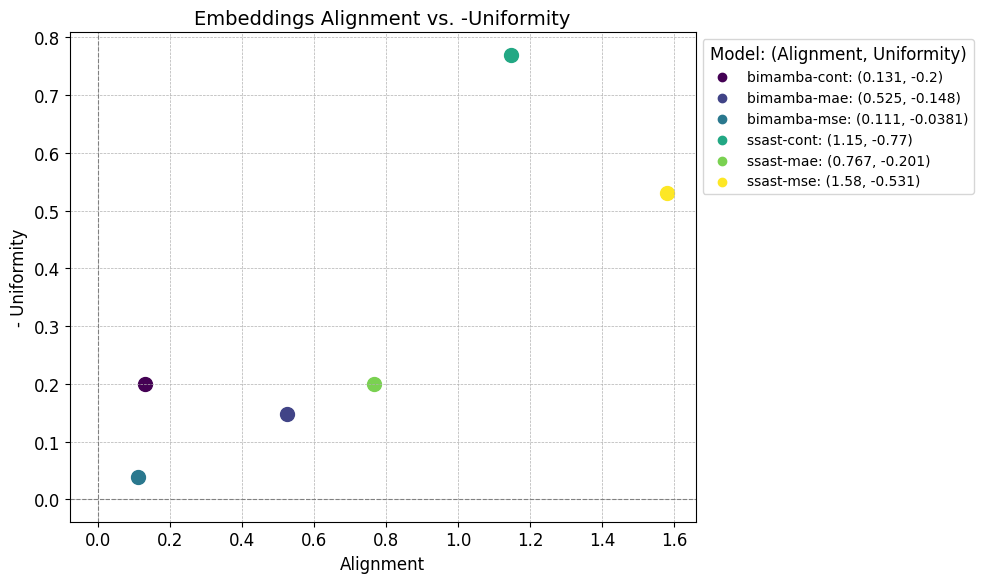

In [149]:
names = list(emb_results.keys())
x = np.array([emb_results[n]["alignment"] for n in names])
u = np.array([emb_results[n]["uniformity"] for n in names])
y_true = -u


fig, ax = plt.subplots(figsize=(10, 6))

for xi, yi, ui, name, c in zip(x, y_true, u, names, colors):
    ax.scatter(xi, yi, color=c, s=100)
    ax.scatter([], [], color=c, label=f"{name}: ({xi:.3g}, {ui:.3g})")

ax.axhline(0, color="gray", lw=0.8, linestyle="--")
ax.axvline(0, color="gray", lw=0.8, linestyle="--")

ax.legend(
    title="Model: (Alignment, Uniformity)",
    bbox_to_anchor=(1, 1),
    loc="upper left",
    fontsize=10,
    title_fontsize=12,
)

ax.set_xlabel("Alignment")
ax.set_ylabel("- Uniformity")
ax.set_title("Embeddings Alignment vs. -Uniformity", fontsize=14)
ax.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()

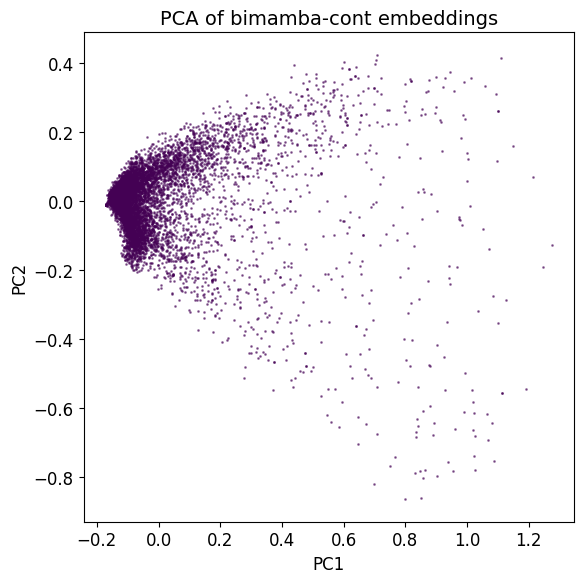

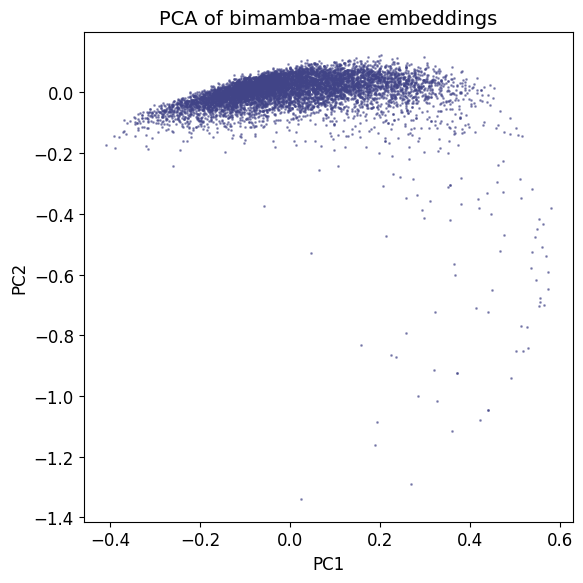

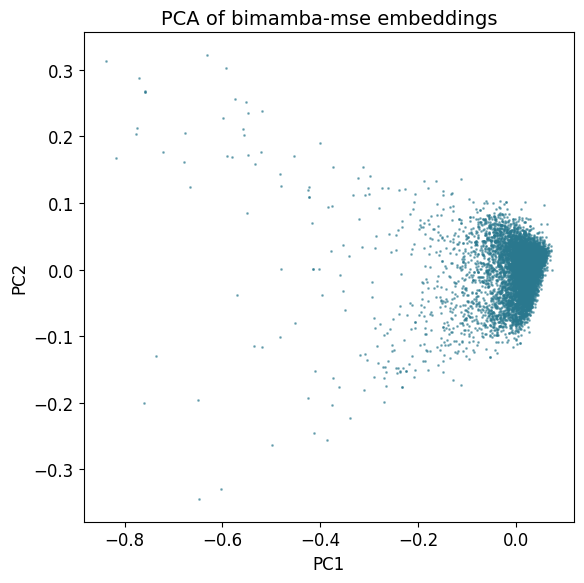

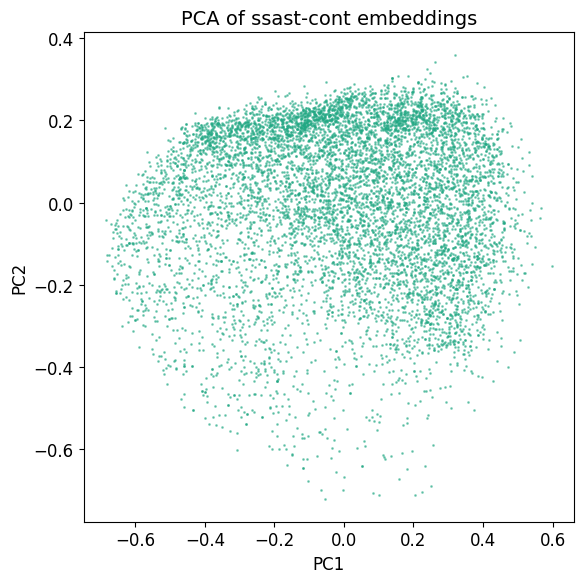

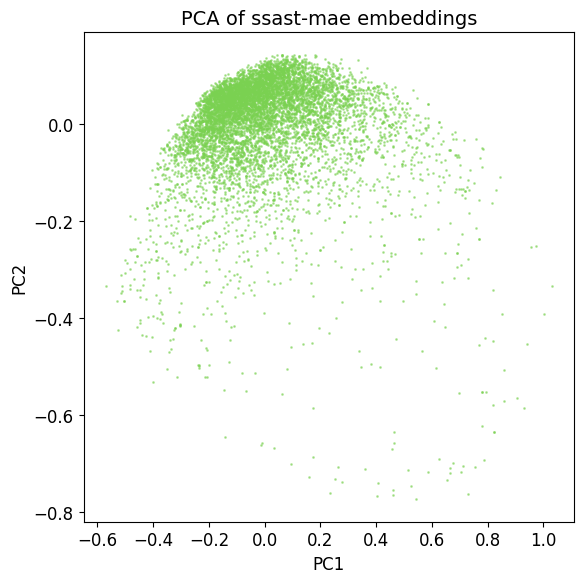

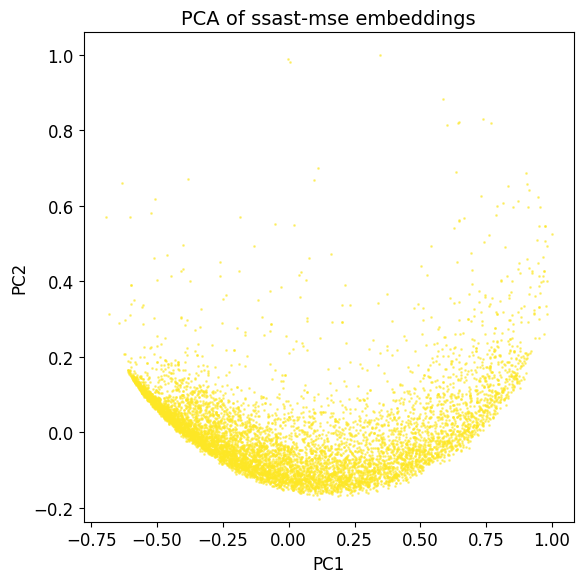

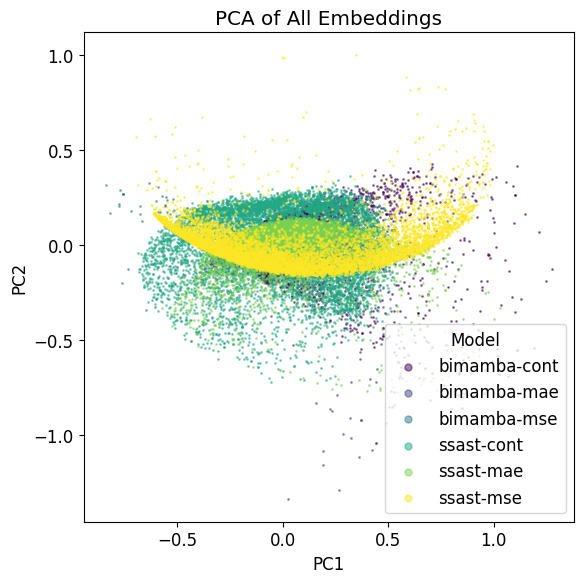

In [150]:
pca = {}

for j, name in enumerate(emb_results.keys()):
    pca[name] = PCA(n_components=3)
    emb = emb_results[name]["emb"].numpy()
    embed = pca[name].fit_transform(emb / np.linalg.norm(emb, axis=1, keepdims=True))
    plt.figure(figsize=(6, 6))
    plt.scatter(embed[:, 0], embed[:, 1], s=1, alpha=0.5, color=colors[j])
    plt.title(f"PCA of {name} embeddings", fontsize=14)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(6, 6))

for j, name in enumerate(emb_results.keys()):
    emb = emb_results[name]["emb"].numpy()
    embed = pca[name].transform(emb / np.linalg.norm(emb, axis=1, keepdims=True))
    plt.scatter(embed[:, 0], embed[:, 1], s=1, alpha=0.5, label=name, color=colors[j])

plt.title("PCA of All Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Model", markerscale=5)
plt.tight_layout()
plt.show()

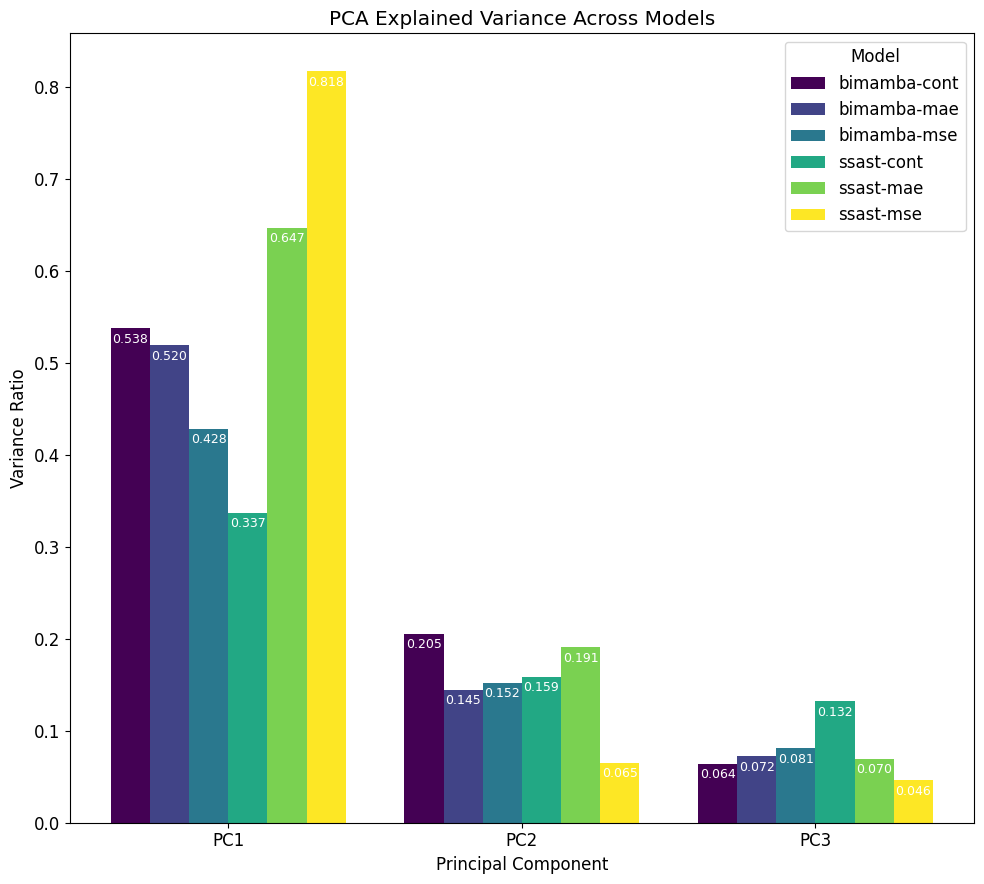

In [151]:
models = list(pca.keys())
components = ["PC1", "PC2", "PC3"]
n_models = len(models)
x = np.arange(len(components))
bar_width = 0.8 / n_models
plt.figure(figsize=(10, 9))

for j, model in enumerate(models):
    values = pca[model].explained_variance_ratio_
    offset = (j - n_models / 2) * bar_width + bar_width / 2
    bars = plt.bar(x + offset, values, width=bar_width, label=model, color=colors[j])

    for bar, val in zip(bars, values):
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height - 0.005,
            f"{val:.3f}",
            ha="center",
            va="top",
            color="white",
            fontsize=9,
        )

plt.xticks(x, components)
plt.xlabel("Principal Component")
plt.ylabel("Variance Ratio")
plt.title("PCA Explained Variance Across Models")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# Targets

In [152]:
def bootstrap_ci(
    metric: Callable, y_true: np.ndarray, y_pred: np.ndarray, alpha: float = 0.05
) -> tuple[float, float]:
    boot_metric = []
    boot_df = pd.DataFrame({"y_true": y_true, "y_pred": y_pred})

    for _ in range(1000):
        boot = boot_df.sample(frac=1, replace=True).reset_index(drop=True)
        metric_value = metric(boot["y_true"], boot["y_pred"])
        boot_metric.append(metric_value)

    return (
        np.round(np.quantile(boot_metric, q=alpha / 2, axis=0), 3).item(),
        np.round(np.quantile(boot_metric, q=1 - alpha / 2, axis=0), 3).item(),
    )

In [153]:
if RUN_INFERENCE:
    targets_dataset = GF23Dataset(
        processor=SpecProcessor(
            location=DATA_LOCATION,
            dataframe=test_metadata,
            spec_transform=SpecNormalize(db_min=DB_MIN, db_max=DB_MAX),
        ),
    )

    targets_dataloader = DataLoader(
        targets_dataset,
        batch_size=64,
        num_workers=16,
        shuffle=False,
    )

## Bird detection

In [154]:
BIRD_MODELS = [
    "bimamba-cls-mae",
    "bimamba-cont",
    "bimamba-mse",
    "ssast-cont",
    "ssast-mae",
    "ssast-mse",
]
BIRD_PATHS = [
    glob.glob(
        os.path.join(
            "checkpoints_final",
            "finetune",
            "bird_detection",
            model,
            "weights_best_*.pt",
        )
    )[0]
    for model in BIRD_MODELS
]

In [155]:
if RUN_INFERENCE:
    bird_models = {}

    for name, path in zip(BIRD_MODELS, BIRD_PATHS):
        if "mamba" in name:
            model = AudioMambaCLF(
                num_classes=2,
                spec_size=(128, 65),
                patch_size=(16, 5),
                channels=1,
                embed_dim=AUDIO_MAMBA_DEFAULT_CONFIG["tiny"]["embed_dim"],
                depth=AUDIO_MAMBA_DEFAULT_CONFIG["tiny"]["depth"],
                ssm_cfg=SSM_CONFIG,
                mask_ratio=0.0,
                drop_path_rate=0.0,
                clf_dropout=0.3,
                clf_hidden_features=AUDIO_MAMBA_DEFAULT_CONFIG["tiny"]["embed_dim"],
                cls_position="middle" if name == "bimamba-cls-mae" else "none",
                use_pred_head=False,
                use_rms_norm=True,
                fused_add_norm=True,
                bi_mamba_type="v1",
                output_type="mean",
            )
        else:
            model = SSASTCLF(
                num_classes=2,
                spec_size=(128, 65),
                patch_size=(16, 5),
                channels=1,
                embed_dim=SSAST_DEFAULT_CONFIG["tiny"]["embed_dim"],
                depth=SSAST_DEFAULT_CONFIG["tiny"]["depth"],
                num_heads=SSAST_DEFAULT_CONFIG["tiny"]["num_heads"],
                mlp_ratio=4,
                mask_ratio=0.0,
                drop_path_rate=0.0,
                pos_drop_rate=0.0,
                clf_dropout=0.3,
                clf_hidden_features=SSAST_DEFAULT_CONFIG["tiny"]["embed_dim"],
                cls_position="none",
                use_pred_head=False,
                use_rms_norm=True,
                output_type="mean",
            )

        model = load_and_freeze_state_dict(model, path, strict=False)
        bird_models[name] = model

In [156]:
if RUN_INFERENCE:
    bird_results = {}

    for name, model in tqdm(bird_models.items(), total=len(bird_models)):
        model = model.cuda(device=DEVICE).eval()
        bird_results[name] = []

        for batch in tqdm(
            iter(targets_dataloader),
            total=len(targets_dataloader),
            desc=name,
            leave=False,
        ):
            spec_origin = batch["spectrogram"].cuda(device=DEVICE)

            with torch.no_grad():
                y_true = model(spec_origin)

            y_true = torch.softmax(y_true.detach().cpu(), dim=1)
            bird_results[name].append(y_true)

        bird_results[name] = torch.cat(bird_results[name], dim=0).numpy()

    with open("results/bird_results.pkl", "wb") as f:
        pickle.dump(bird_results, f)

with open("results/bird_results.pkl", "rb") as f:
    bird_results = pickle.load(f)

In [157]:
bird_results["bimamba-mae"] = bird_results.pop("bimamba-cls-mae")
bird_results = dict(sorted(bird_results.items()))

In [158]:
# y_true = test_metadata["Bird_label"].to_numpy(dtype=np.int64)
# y_pred = {}

# for name in bird_results.keys():
#     y_pred[name] = bird_results[name].argmax(axis=1)
#     print(f"--- {name} ---")
#     print(
#         f"Accuracy: {accuracy_score(y_true, y_pred[name]):.3g}, 95% CI: {bootstrap_ci(accuracy_score, y_true, y_pred[name])}"
#     )
#     print(
#         f"Precision: {precision_score(y_true, y_pred[name]):.3g}, 95% CI: {bootstrap_ci(precision_score, y_true, y_pred[name])}"
#     )
#     print(
#         f"Recall: {recall_score(y_true, y_pred[name]):.3g}, 95% CI: {bootstrap_ci(recall_score, y_true, y_pred[name])}"
#     )
#     print(
#         f"F1: {f1_score(y_true, y_pred[name]):.3g}, 95% CI: {bootstrap_ci(f1_score, y_true, y_pred[name])}"
#     )
#     print()

In [159]:
# for name in bird_results.keys():
#     print(f"--- {name} ---")
#     print("Bird label Classification Report")
#     print(classification_report(y_true, y_pred[name], zero_division=0))
#     cm = confusion_matrix(
#         y_true,
#         y_pred[name],
#         labels=[0, 1],
#         normalize="true",
#     )
#     disp = ConfusionMatrixDisplay(
#         confusion_matrix=cm,
#         display_labels=["Absence", "Presence"],
#     )
#     disp.plot(cmap="Blues", colorbar=False)
#     plt.title(f"{name} - Bird label Confusion Matrix")
#     plt.tight_layout()
#     plt.show()

## Temporal

In [160]:
def angle(sin: np.ndarray, cos: np.ndarray) -> np.ndarray:
    return np.mod(np.arctan2(sin, cos), 2 * np.pi)


def angle_diff(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    return (a - b + np.pi) % (2 * np.pi) - np.pi

In [161]:
TEMPORAL_MODELS = [
    "bimamba-cls-mae",
    "bimamba-cont",
    "bimamba-mse",
    "ssast-cont",
    "ssast-mae",
    "ssast-mse",
]
TEMPORAL_PATHS = [
    glob.glob(
        os.path.join(
            "checkpoints_final",
            "finetune",
            "temporal",
            model,
            "weights_best_*.pt",
        )
    )[0]
    for model in TEMPORAL_MODELS
]

In [162]:
if RUN_INFERENCE:
    temp_models = {}

    for name, path in zip(TEMPORAL_MODELS, TEMPORAL_PATHS):
        if "mamba" in name:
            model = AudioMambaCLF(
                num_classes=2,
                spec_size=(128, 65),
                patch_size=(16, 5),
                channels=1,
                embed_dim=AUDIO_MAMBA_DEFAULT_CONFIG["tiny"]["embed_dim"],
                depth=AUDIO_MAMBA_DEFAULT_CONFIG["tiny"]["depth"],
                ssm_cfg=SSM_CONFIG,
                mask_ratio=0.0,
                drop_path_rate=0.0,
                clf_dropout=0.3,
                clf_hidden_features=AUDIO_MAMBA_DEFAULT_CONFIG["tiny"]["embed_dim"],
                cls_position="middle" if name == "bimamba-cls-mae" else "none",
                use_pred_head=False,
                use_rms_norm=True,
                fused_add_norm=True,
                bi_mamba_type="v1",
                output_type="mean",
            )
        else:
            model = SSASTCLF(
                num_classes=2,
                spec_size=(128, 65),
                patch_size=(16, 5),
                channels=1,
                embed_dim=SSAST_DEFAULT_CONFIG["tiny"]["embed_dim"],
                depth=SSAST_DEFAULT_CONFIG["tiny"]["depth"],
                num_heads=SSAST_DEFAULT_CONFIG["tiny"]["num_heads"],
                mlp_ratio=4,
                mask_ratio=0.0,
                drop_path_rate=0.0,
                pos_drop_rate=0.0,
                clf_dropout=0.3,
                clf_hidden_features=SSAST_DEFAULT_CONFIG["tiny"]["embed_dim"],
                cls_position="none",
                use_pred_head=False,
                use_rms_norm=True,
                output_type="mean",
            )

        model = load_and_freeze_state_dict(model, path, strict=False)
        temp_models[name] = model

In [163]:
if RUN_INFERENCE:
    temp_results = {}

    for name, model in tqdm(temp_models.items(), total=len(temp_models)):
        model = model.cuda(device=DEVICE).eval()
        temp_results[name] = []

        for batch in tqdm(
            iter(targets_dataloader),
            total=len(targets_dataloader),
            desc=name,
            leave=False,
        ):
            spec_origin = batch["spectrogram"].cuda(device=DEVICE)

            with torch.no_grad():
                y_true = model(spec_origin)

            y_true = y_true.detach().cpu()
            y_true /= torch.norm(y_true, dim=1, keepdim=True)
            temp_results[name].append(y_true)

        temp_results[name] = torch.cat(temp_results[name], dim=0).numpy()

    with open("results/temp_results.pkl", "wb") as f:
        pickle.dump(temp_results, f)

with open("results/temp_results.pkl", "rb") as f:
    temp_results = pickle.load(f)

In [164]:
temp_results["bimamba-mae"] = temp_results.pop("bimamba-cls-mae")
temp_results = dict(sorted(temp_results.items()))

In [165]:
y_true = test_metadata["Time_of_Day_angle"].to_numpy()
y_pred = {}
y_error = {}

for name in temp_results.keys():
    y_pred[name] = angle(temp_results[name][:, 0], temp_results[name][:, 1])
    y_error[name] = angle_diff(y_pred[name], y_true) / np.pi

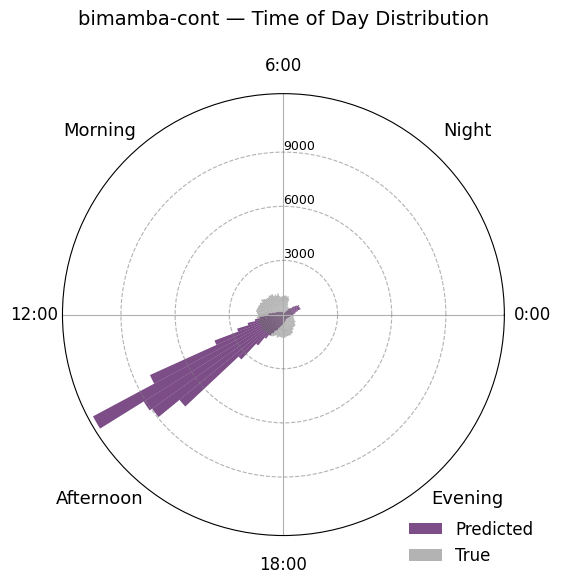

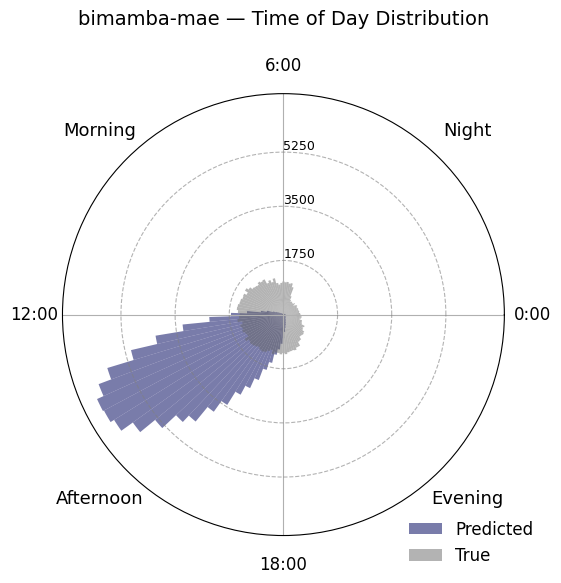

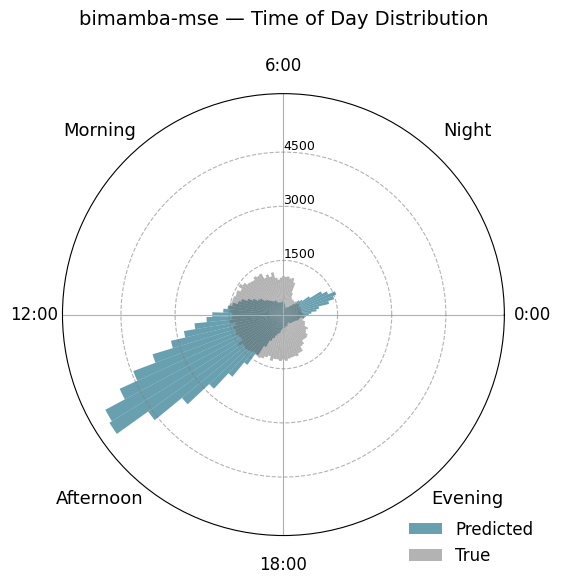

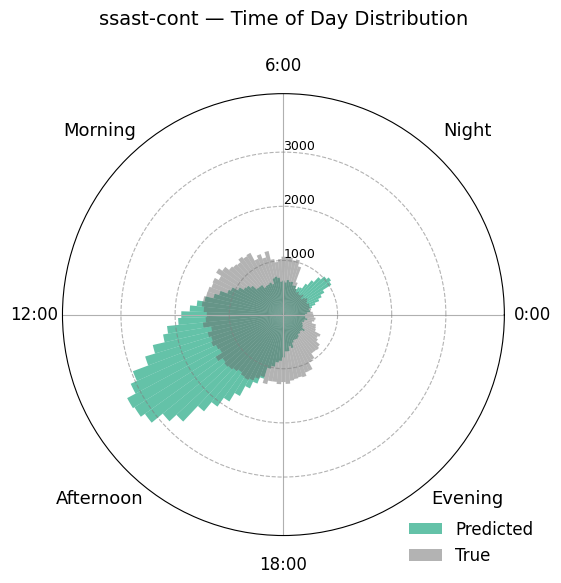

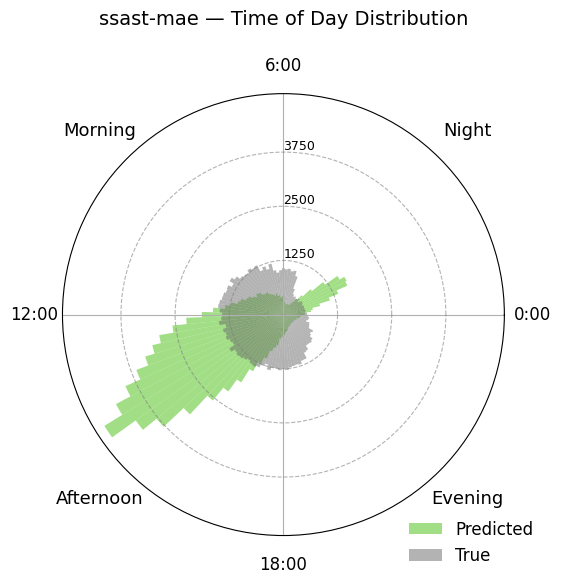

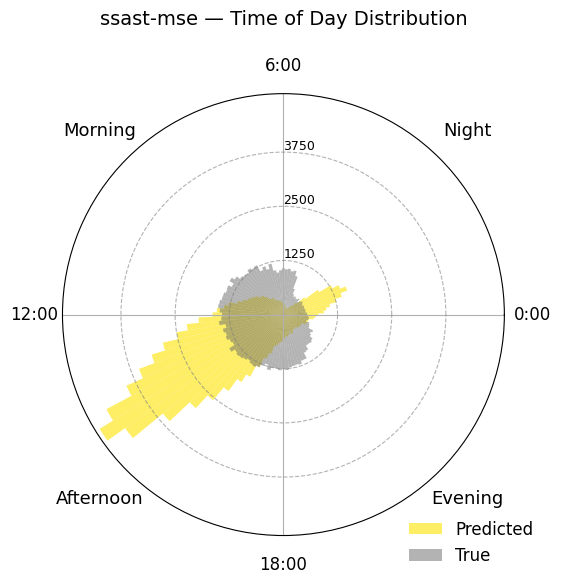

In [166]:
for idx, name in enumerate(temp_results.keys()):
    bins = 24 * 4
    pred_counts, edges = np.histogram(y_pred[name], bins=bins, range=(0, 2 * np.pi))
    true_counts, _ = np.histogram(y_true, bins=bins, range=(0, 2 * np.pi))
    widths = np.diff(edges)

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={"projection": "polar"})

    ax.bar(
        edges[:-1],
        pred_counts,
        width=widths,
        edgecolor="none",
        facecolor=colors[idx],
        alpha=0.7,
        label="Predicted",
    )
    ax.bar(
        edges[:-1],
        true_counts,
        width=widths,
        edgecolor="none",
        facecolor="dimgray",
        alpha=0.5,
        label="True",
    )

    hour_ticks = np.array([0, 6, 12, 18]) / 24 * 2 * np.pi
    hour_labels = ["0:00", "6:00", "12:00", "18:00"]
    ax.set_xticks(hour_ticks)
    ax.set_xticklabels(hour_labels, fontsize=12)
    ax.tick_params(axis="x", which="major", pad=10)

    part_mid = np.array([3, 9, 15, 21]) / 24 * 2 * np.pi
    part_labels = ["Night", "Morning", "Afternoon", "Evening"]
    max_count = max(pred_counts.max(), true_counts.max())
    power_of_ten = 1000
    nice_max = int(np.ceil(max_count / power_of_ten)) * power_of_ten
    r_out = nice_max * 1.2

    for angle, lab in zip(part_mid, part_labels):
        ax.text(angle, r_out, lab, ha="center", va="center", fontsize=13)

    n_grids = 4
    step = nice_max / n_grids
    r_grids = np.arange(step, nice_max + 0.1, step)[:-1]
    r_labels = [f"{int(r):d}" for r in r_grids]
    ax.set_rgrids(r_grids, labels=r_labels, angle=90, fontsize=9)  # type: ignore
    ax.set_ylim(0, nice_max * 1.02)

    for line in ax.yaxis.get_gridlines():
        line.set_linestyle("--")
        line.set_color("gray")
        line.set_alpha(0.6)

    ax.grid(True)
    ax.legend(loc="lower right", bbox_to_anchor=(1.1, -0.1), frameon=False, fontsize=12)

    ax.set_title(f"{name} — Time of Day Distribution", va="bottom", fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

In [167]:
for name in temp_results.keys():
    print(f"--- {name} ---")
    print(f"Time of Day MAE: {np.mean(np.abs(y_error[name])):.3g}")
    print(f"Absolute Error Std: {np.std(np.abs(y_error[name])):.3g}")
    print()

--- bimamba-cont ---
Time of Day MAE: 0.322
Absolute Error Std: 0.225

--- bimamba-mae ---
Time of Day MAE: 0.381
Absolute Error Std: 0.259

--- bimamba-mse ---
Time of Day MAE: 0.284
Absolute Error Std: 0.219

--- ssast-cont ---
Time of Day MAE: 0.19
Absolute Error Std: 0.176

--- ssast-mae ---
Time of Day MAE: 0.257
Absolute Error Std: 0.204

--- ssast-mse ---
Time of Day MAE: 0.278
Absolute Error Std: 0.217



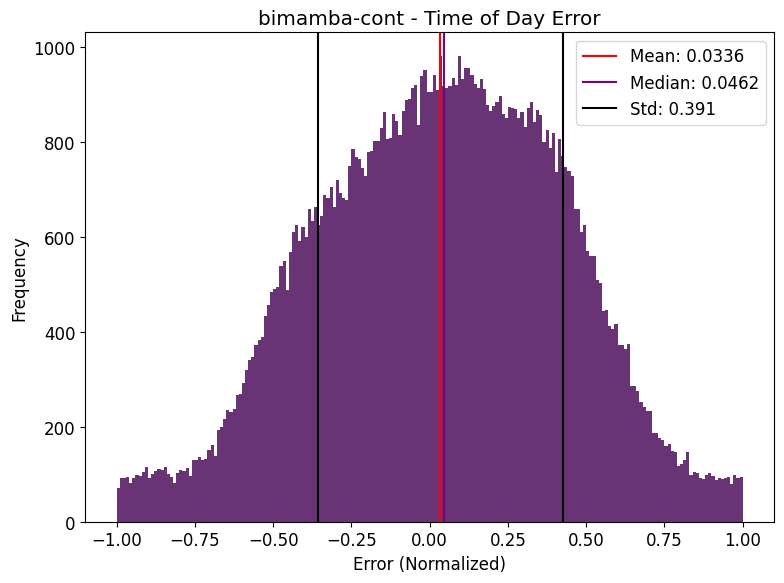

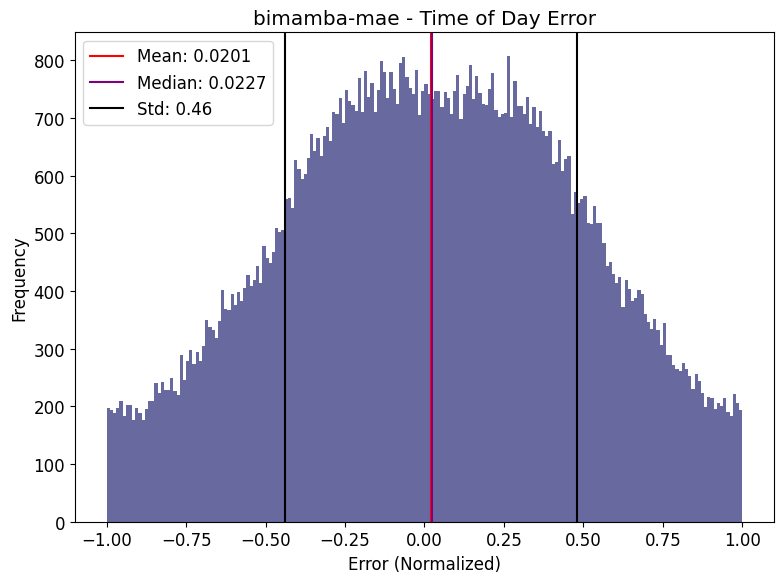

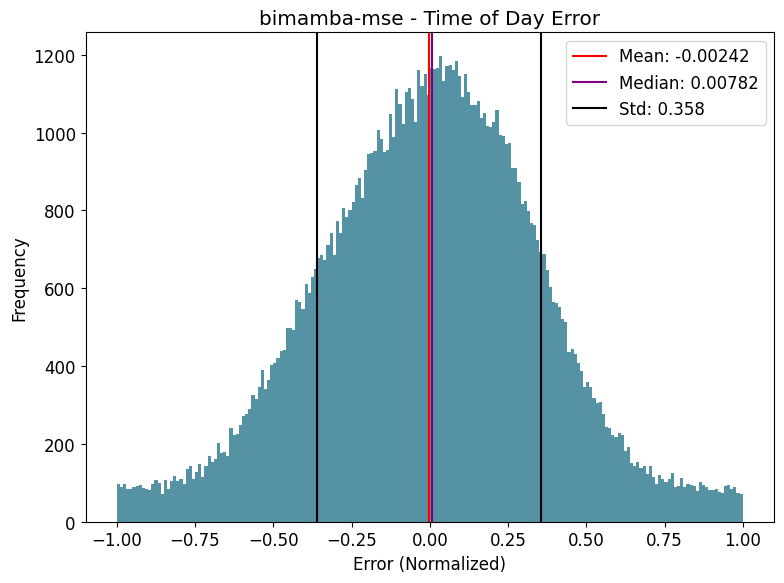

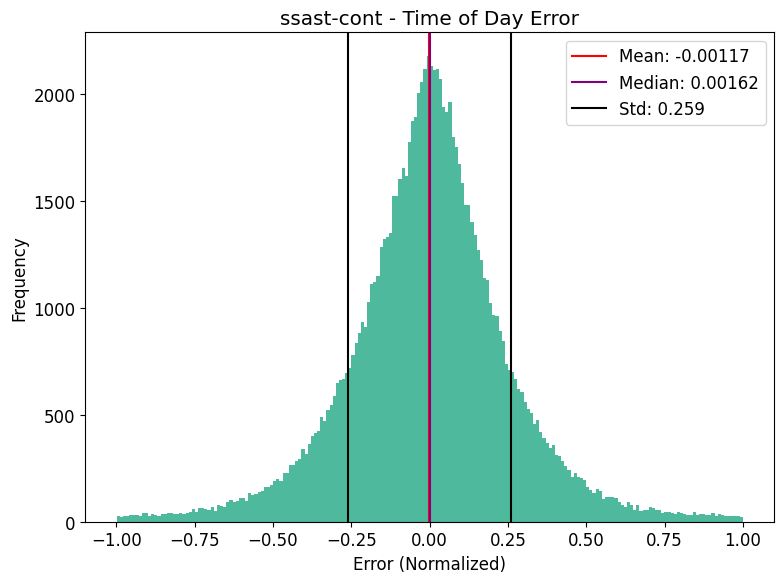

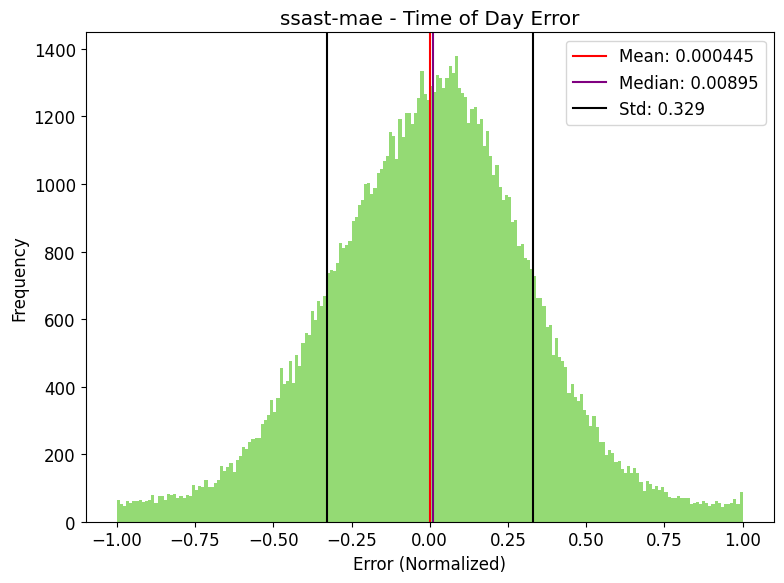

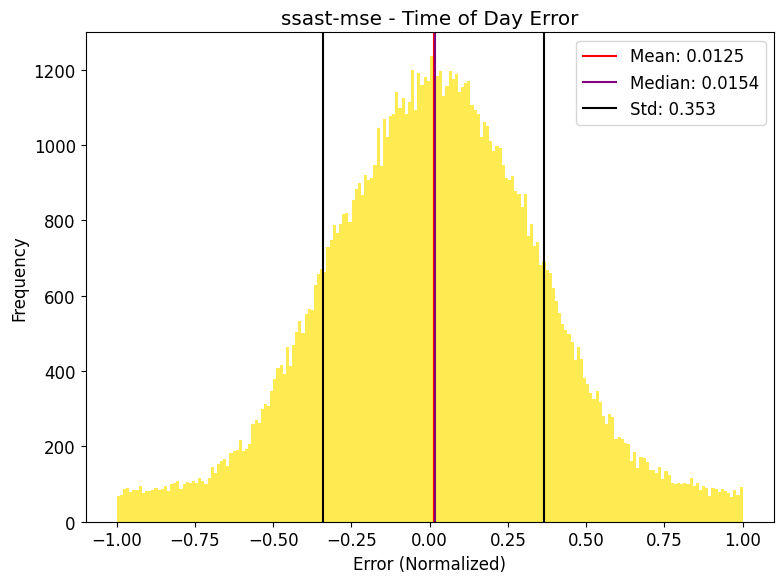

In [168]:
for i, name in enumerate(temp_results.keys()):
    plt.figure(figsize=(8, 6))
    plt.hist(
        y_error[name],
        bins=200,
        alpha=0.8,
        color=colors[i],
    )
    plt.axvline(
        np.mean(y_error[name]),
        color="red",
        label=f"Mean: {np.mean(y_error[name]):.3g}",
    )
    plt.axvline(
        np.median(y_error[name]),
        color="purple",
        label=f"Median: {np.median(y_error[name]):.3g}",
    )
    plt.axvline(
        np.mean(y_error[name]) + np.std(y_error[name]),  # type: ignore
        color="black",
        label=f"Std: {np.std(y_error[name]):.3g}",
    )
    plt.axvline(
        np.mean(y_error[name]) - np.std(y_error[name]),  # type: ignore
        color="black",
    )
    plt.xlabel("Error (Normalized)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title(f"{name} - Time of Day Error")
    plt.tight_layout()

In [169]:
num_bins = 4
bin_width = 2 * np.pi / num_bins

y_true_binned = ((y_true % (2 * np.pi)) // bin_width).astype(int)

y_pred_binned = {}
for name in temp_results.keys():
    y_pred_binned[name] = ((y_pred[name] % (2 * np.pi)) // bin_width).astype(int)

--- bimamba-cont ---
Time of Day Classification Report
              precision    recall  f1-score   support

           0       0.64      0.47      0.54     14771
           1       0.45      0.09      0.15     30919
           2       0.39      0.90      0.55     32611
           3       0.40      0.16      0.22     21699

    accuracy                           0.42    100000
   macro avg       0.47      0.40      0.37    100000
weighted avg       0.45      0.42      0.35    100000



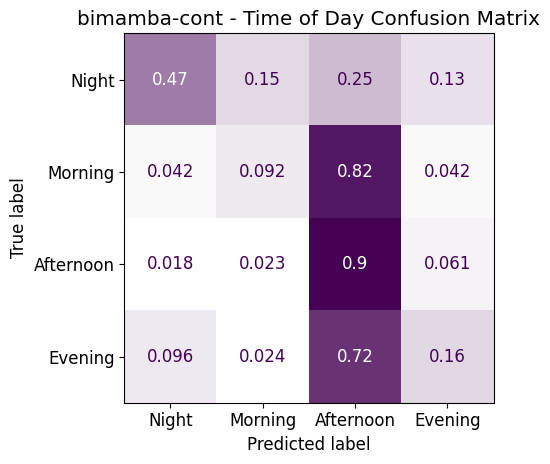

--- bimamba-mae ---
Time of Day Classification Report
              precision    recall  f1-score   support

           0       0.76      0.04      0.07     14771
           1       0.62      0.08      0.13     30919
           2       0.35      0.97      0.51     32611
           3       0.27      0.06      0.09     21699

    accuracy                           0.36    100000
   macro avg       0.50      0.28      0.20    100000
weighted avg       0.48      0.36      0.24    100000



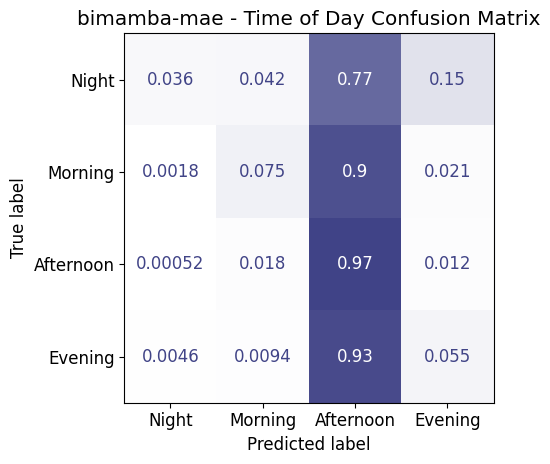

--- bimamba-mse ---
Time of Day Classification Report
              precision    recall  f1-score   support

           0       0.60      0.63      0.61     14771
           1       0.56      0.31      0.40     30919
           2       0.45      0.81      0.58     32611
           3       0.49      0.20      0.29     21699

    accuracy                           0.50    100000
   macro avg       0.53      0.49      0.47    100000
weighted avg       0.52      0.50      0.47    100000



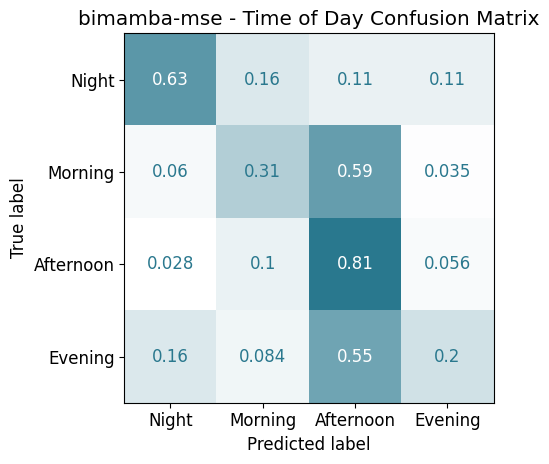

--- ssast-cont ---
Time of Day Classification Report
              precision    recall  f1-score   support

           0       0.74      0.82      0.78     14771
           1       0.72      0.50      0.59     30919
           2       0.56      0.86      0.68     32611
           3       0.76      0.41      0.53     21699

    accuracy                           0.65    100000
   macro avg       0.69      0.65      0.65    100000
weighted avg       0.68      0.65      0.63    100000



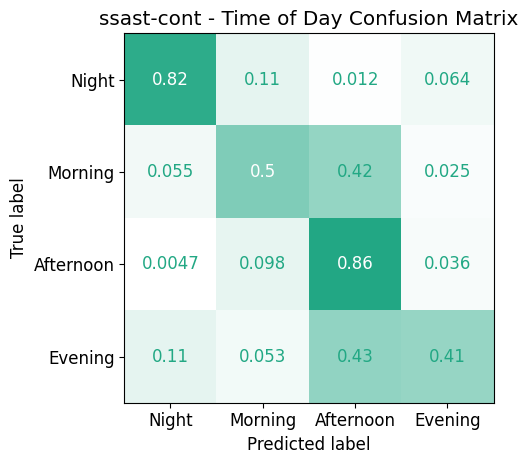

--- ssast-mae ---
Time of Day Classification Report
              precision    recall  f1-score   support

           0       0.63      0.70      0.67     14771
           1       0.61      0.35      0.44     30919
           2       0.47      0.84      0.61     32611
           3       0.56      0.20      0.30     21699

    accuracy                           0.53    100000
   macro avg       0.57      0.52      0.50    100000
weighted avg       0.56      0.53      0.50    100000



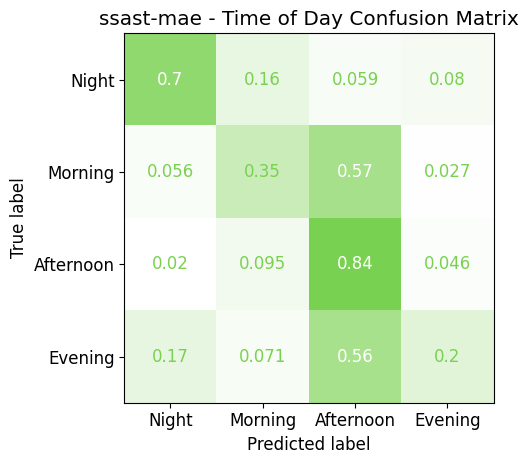

--- ssast-mse ---
Time of Day Classification Report
              precision    recall  f1-score   support

           0       0.60      0.61      0.60     14771
           1       0.59      0.30      0.40     30919
           2       0.46      0.80      0.58     32611
           3       0.49      0.27      0.35     21699

    accuracy                           0.50    100000
   macro avg       0.53      0.50      0.48    100000
weighted avg       0.53      0.50      0.48    100000



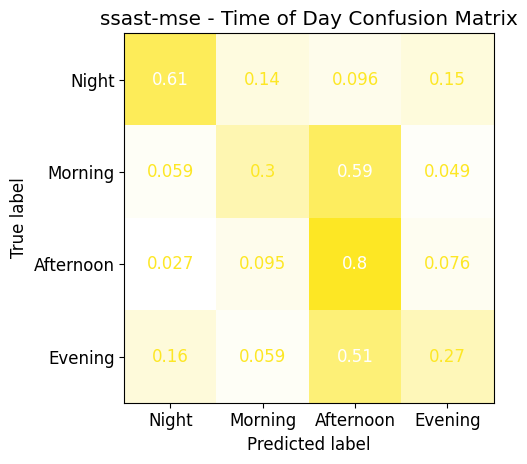

In [170]:
for idx, name in enumerate(temp_results.keys()):
    print(f"--- {name} ---")
    print("Time of Day Classification Report")
    print(classification_report(y_true_binned, y_pred_binned[name], zero_division=0))
    cm = confusion_matrix(
        y_true_binned,
        y_pred_binned[name],
        labels=[0, 1, 2, 3],
        normalize="true",
    )
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Night", "Morning", "Afternoon", "Evening"],
    )
    cmap = LinearSegmentedColormap.from_list(
        name="WhiteToBase", colors=["white", colors[idx]]
    )
    disp.plot(cmap=cmap, colorbar=False)
    plt.title(f"{name} - Time of Day Confusion Matrix")
    plt.tight_layout()
    plt.show()

## Weather

In [171]:
def hellinger_distance(
    dist1: np.ndarray,
    dist2: np.ndarray,
    bins: int = 50,
    range: Optional[tuple[float, float]] = None,
):
    hist1, bin_edges = np.histogram(dist1, bins=bins, range=range, density=True)
    hist2, _ = np.histogram(dist2, bins=bin_edges, density=True)

    bin_widths = np.diff(bin_edges)
    p = hist1 * bin_widths
    q = hist2 * bin_widths

    return np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q)) ** 2))


def huber_loss(y_pred: np.ndarray, y_true: np.ndarray, delta: float = 1.0):
    huber_mse = 0.5 * (y_true - y_pred) ** 2
    huber_mae = delta * (np.abs(y_true - y_pred) - 0.5 * delta)

    return np.where(np.abs(y_true - y_pred) <= delta, huber_mse, huber_mae)

In [172]:
WEATHER_MODELS = [
    "bimamba-cls-mae",
    "bimamba-cont",
    "bimamba-mse",
    "ssast-cont",
    "ssast-mae",
    "ssast-mse",
]
WEATHER_PATHS = [
    glob.glob(
        os.path.join(
            "checkpoints_final",
            "finetune",
            "weather",
            model,
            "weights_best_*.pt",
        )
    )[0]
    for model in WEATHER_MODELS
]

In [173]:
if RUN_INFERENCE:
    weather_models = {}

    for name, path in zip(WEATHER_MODELS, WEATHER_PATHS):
        if "mamba" in name:
            model = AudioMambaCLF(
                num_classes=2,
                spec_size=(128, 65),
                patch_size=(16, 5),
                channels=1,
                embed_dim=AUDIO_MAMBA_DEFAULT_CONFIG["tiny"]["embed_dim"],
                depth=AUDIO_MAMBA_DEFAULT_CONFIG["tiny"]["depth"],
                ssm_cfg=SSM_CONFIG,
                mask_ratio=0.0,
                drop_path_rate=0.0,
                clf_dropout=0.3,
                clf_hidden_features=AUDIO_MAMBA_DEFAULT_CONFIG["tiny"]["embed_dim"],
                cls_position="middle" if name == "bimamba-cls-mae" else "none",
                use_pred_head=False,
                use_rms_norm=True,
                fused_add_norm=True,
                bi_mamba_type="v1",
                output_type="mean",
            )
        else:
            model = SSASTCLF(
                num_classes=2,
                spec_size=(128, 65),
                patch_size=(16, 5),
                channels=1,
                embed_dim=SSAST_DEFAULT_CONFIG["tiny"]["embed_dim"],
                depth=SSAST_DEFAULT_CONFIG["tiny"]["depth"],
                num_heads=SSAST_DEFAULT_CONFIG["tiny"]["num_heads"],
                mlp_ratio=4,
                mask_ratio=0.0,
                drop_path_rate=0.0,
                pos_drop_rate=0.0,
                clf_dropout=0.3,
                clf_hidden_features=SSAST_DEFAULT_CONFIG["tiny"]["embed_dim"],
                cls_position="none",
                use_pred_head=False,
                use_rms_norm=True,
                output_type="mean",
            )

        model = load_and_freeze_state_dict(model, path, strict=False)
        weather_models[name] = model

In [174]:
if RUN_INFERENCE:
    weather_results = {}

    for name, model in tqdm(weather_models.items(), total=len(weather_models)):
        model = model.cuda(device=DEVICE).eval()
        weather_results[name] = {"precipRate_label": [], "windspeedAvg_label": []}

        for batch in tqdm(
            iter(targets_dataloader),
            total=len(targets_dataloader),
            desc=name,
            leave=False,
        ):
            spec_origin = batch["spectrogram"].cuda(device=DEVICE)

            with torch.no_grad():
                y_true = model(spec_origin)

            y_true = torch.maximum(y_true.detach().cpu(), torch.tensor(0.0))
            weather_results[name]["precipRate_label"].append(y_true[:, 0])
            weather_results[name]["windspeedAvg_label"].append(y_true[:, 1])

        weather_results[name]["precipRate_label"] = np.maximum(
            torch.cat(weather_results[name]["precipRate_label"], dim=0).numpy(), 0
        )
        weather_results[name]["windspeedAvg_label"] = np.maximum(
            torch.cat(weather_results[name]["windspeedAvg_label"], dim=0).numpy(), 0
        )

    with open("results/weather_results.pkl", "wb") as f:
        pickle.dump(weather_results, f)

with open("results/weather_results.pkl", "rb") as f:
    weather_results = pickle.load(f)

In [175]:
weather_results["bimamba-mae"] = weather_results.pop("bimamba-cls-mae")
weather_results = dict(sorted(weather_results.items()))

Hellinger Distance for bimamba-cont Precipitation Rate : 0.8909413461130494


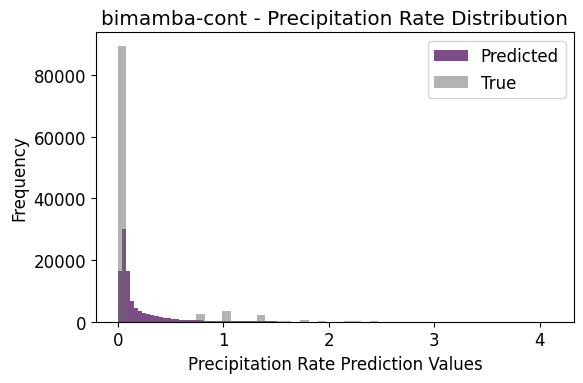

Hellinger Distance for bimamba-cont Average Wind Speed : 0.7263772829396642


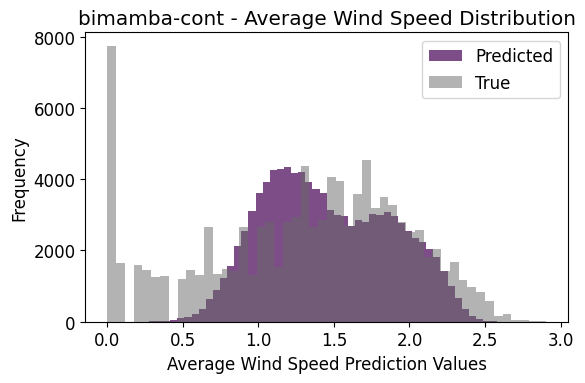

Hellinger Distance for bimamba-mae Precipitation Rate : 0.5922291857334293


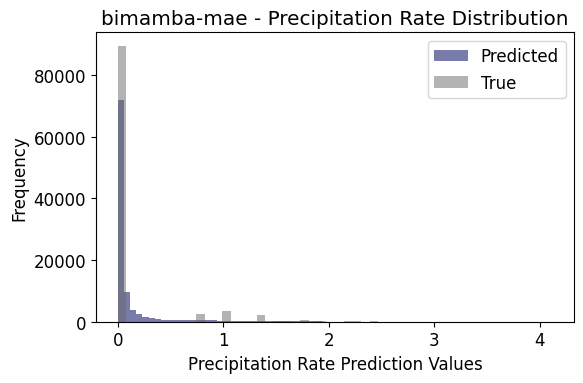

Hellinger Distance for bimamba-mae Average Wind Speed : 0.6765483666107792


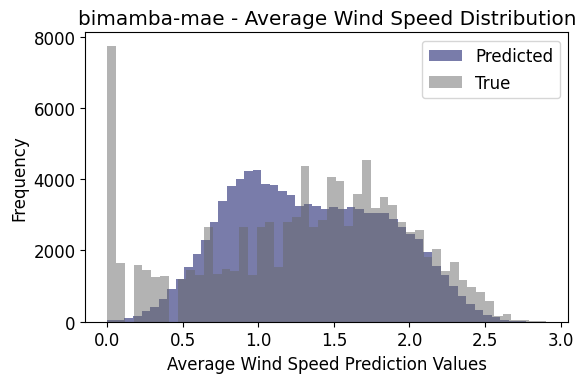

Hellinger Distance for bimamba-mse Precipitation Rate : 0.6266377239770585


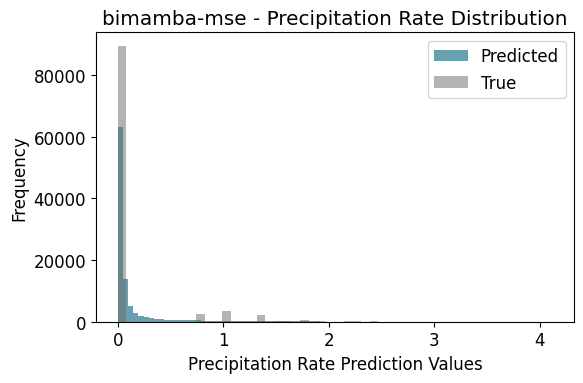

Hellinger Distance for bimamba-mse Average Wind Speed : 0.6909462970247513


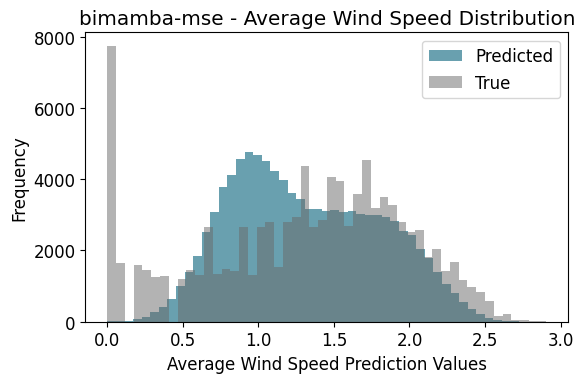

Hellinger Distance for ssast-cont Precipitation Rate : 0.46290678325763485


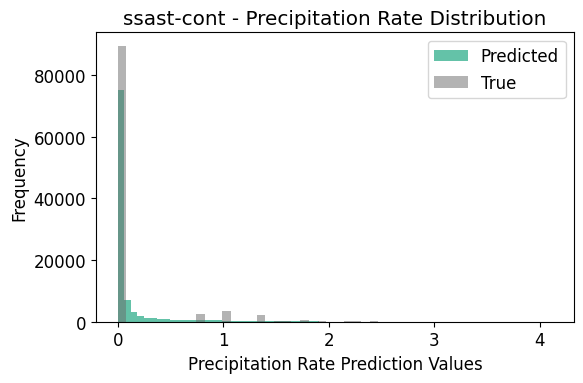

Hellinger Distance for ssast-cont Average Wind Speed : 0.6483647823255568


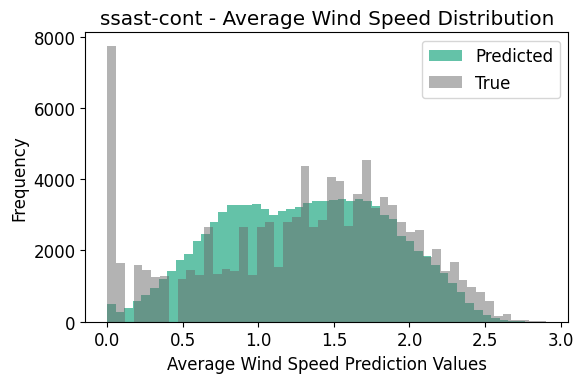

Hellinger Distance for ssast-mae Precipitation Rate : 0.5607651876216136


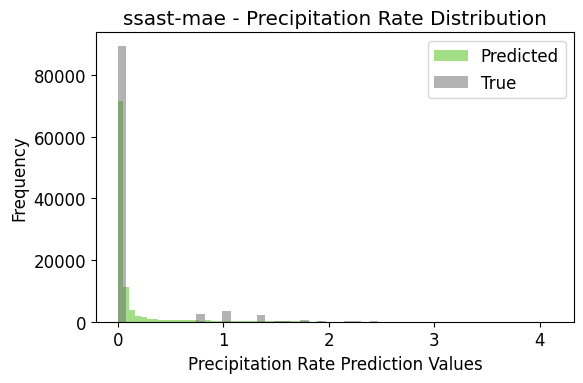

Hellinger Distance for ssast-mae Average Wind Speed : 0.6845245592731818


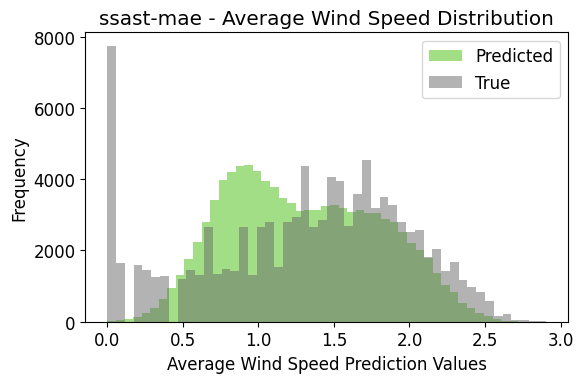

Hellinger Distance for ssast-mse Precipitation Rate : 0.6049004963535921


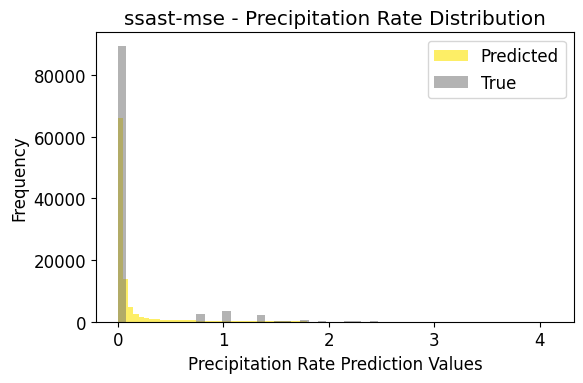

Hellinger Distance for ssast-mse Average Wind Speed : 0.6800932110358271


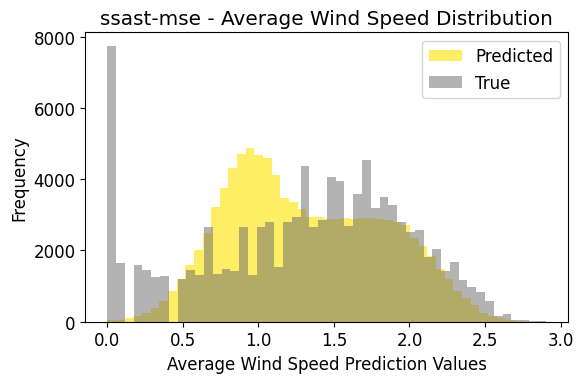

In [ ]:
label_names = {
    "precipRate_label": "Precipitation Rate",
    "windspeedAvg_label": "Average Wind Speed",
}

for j, (model_name, labels_dict) in enumerate(weather_results.items()):
    for label_key in ("precipRate_label", "windspeedAvg_label"):
        y_true = test_metadata[label_key].to_numpy(dtype=np.float32)
        y_pred = labels_dict[label_key]

        hellinger_dist = hellinger_distance(y_true, y_pred, bins=50, range=(0, 1))
        print(
            "Hellinger Distance for",
            model_name,
            "-",
            label_names[label_key],
            ":",
            hellinger_dist,
        )

        plt.figure(figsize=(6, 4))
        n_bins = 50
        counts, bins, patches = plt.hist(
            y_pred, bins=n_bins, color=colors[j], alpha=0.7, label="Predicted"
        )
        plt.hist(
            y_true,
            bins=n_bins,
            color="dimgray",
            alpha=0.5,
            label="True",
        )

        plt.xlabel(f"{label_names[label_key]} Prediction Values")
        plt.ylabel("Frequency")
        plt.title(f"{model_name} - {label_names[label_key]} Distribution")
        plt.legend(loc="upper right")

        plt.tight_layout()
        plt.show()

In [181]:
linestyles = [
    "dotted",
    "dashed",
    "dashdot",
    "solid",
    (0, (1, 1)),  # loosely dotted
    (0, (5, 1)),  # loosely dashed
]
markers = ["v", "s", "p", "o", "x", "D"]

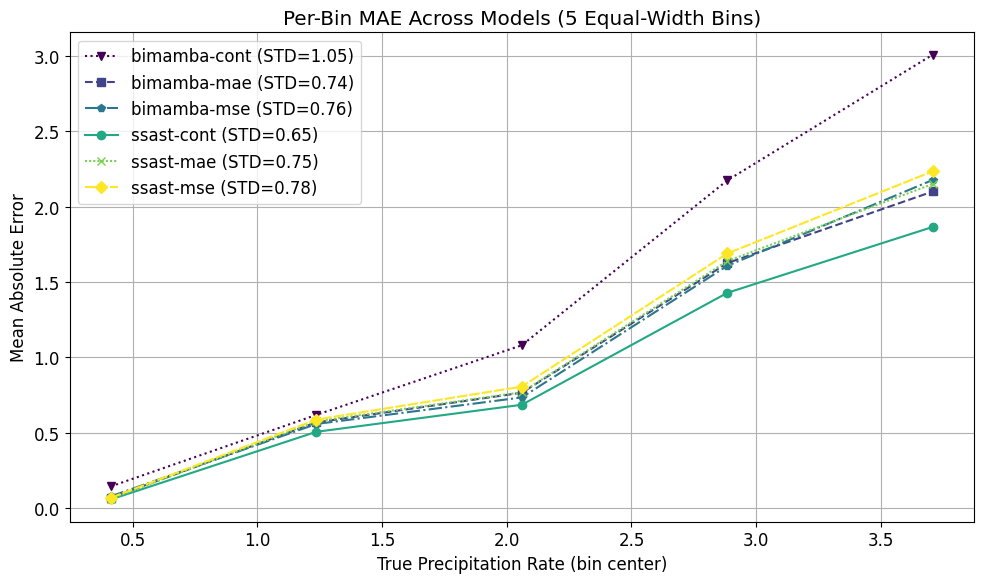

In [185]:
y_true = test_metadata["precipRate_label"].to_numpy(dtype=np.float32)
y_pred_dict = {
    name: r["precipRate_label"].flatten() for name, r in weather_results.items()
}

n_bins = 5
bins = np.linspace(y_true.min(), y_true.max(), n_bins + 1)
bin_centers = (bins[:-1] + bins[1:]) / 2

plt.figure(figsize=(10, 6))

for idx, (name, y_pred) in enumerate(y_pred_dict.items()):
    errors = np.abs(y_pred - y_true)
    bin_idx = np.digitize(y_true, bins, right=False) - 1
    bin_idx = np.clip(bin_idx, 0, n_bins - 1)
    means = np.array([errors[bin_idx == b].mean() for b in range(n_bins)])
    stds = np.array([errors[bin_idx == b].std() for b in range(n_bins)])
    std_means = means.std()
    plt.plot(
        bin_centers,
        means,
        marker=markers[idx],
        linestyle=linestyles[idx],
        color=colors[idx],
        label=f"{name} (STD={std_means:.2f})",
    )

plt.title("Per-Bin MAE Across Models (5 Equal-Width Bins)")
plt.xlabel("True Precipitation Rate (bin center)")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

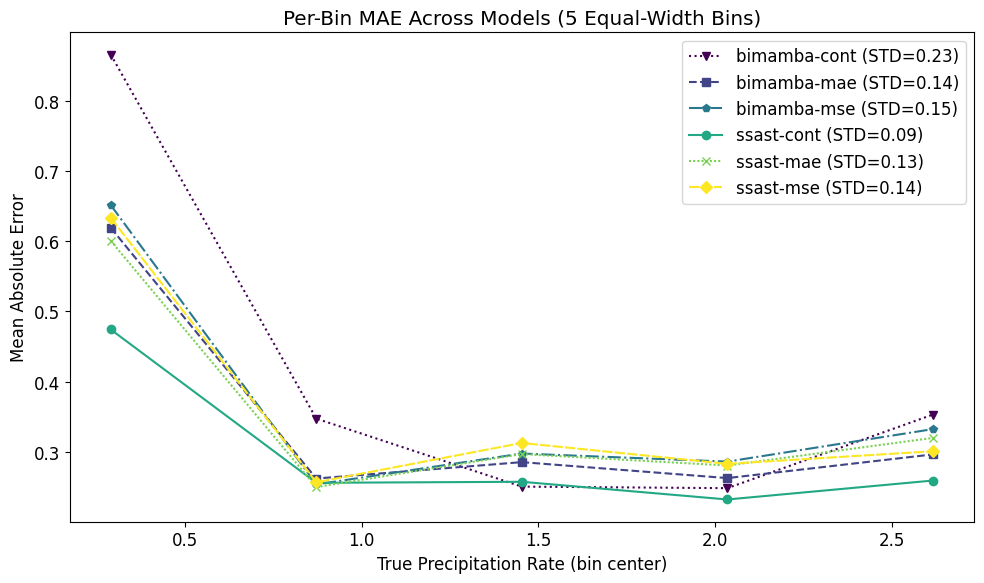

In [ ]:
y_true = test_metadata["windspeedAvg_label"].to_numpy(dtype=np.float32)
y_pred_dict = {
    name: r["windspeedAvg_label"].flatten() for name, r in weather_results.items()
}

n_bins = 5
bins = np.linspace(y_true.min(), y_true.max(), n_bins + 1)
bin_centers = (bins[:-1] + bins[1:]) / 2

plt.figure(figsize=(10, 6))

for idx, (name, y_pred) in enumerate(y_pred_dict.items()):
    errors = np.abs(y_pred - y_true)
    bin_idx = np.digitize(y_true, bins, right=False) - 1
    bin_idx = np.clip(bin_idx, 0, n_bins - 1)
    means = np.array([errors[bin_idx == b].mean() for b in range(n_bins)])
    stds = np.array([errors[bin_idx == b].std() for b in range(n_bins)])
    std_means = means.std()
    plt.plot(
        bin_centers,
        means,
        marker=markers[idx],
        linestyle=linestyles[idx],
        color=colors[idx],
        label=f"{name} (STD={std_means:.2f})",
    )

plt.title("Per-Bin MAE Across Models (5 Equal-Width Bins)")
plt.xlabel("True Precipitation Rate (bin center)")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()